<a href="https://colab.research.google.com/github/coachsummer/Project-X/blob/main/002_Head%20CT-Hemorrhage/002_Head_CT_Hemorrhage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01_data_store

In [1]:
import glob
import os
import pandas as pd 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
# 01_data_store

drive.mount('/gdrive', force_remount = True)
working_dir = 'ct'
colab_default_dir = '/gdrive/My Drive/Colab Notebooks/'
original_dir = os.getcwd()

Mounted at /gdrive


In [3]:
try:
  os.chdir(colab_default_dir)
  if not os.path.exists(working_dir):
    os.mkdir(working_dir)
  os.chdir(working_dir)
  print('current dir = ', os.getcwd())
except Exception as err:
  os.chdir(original_dir)
  print(str(err))

current dir =  /gdrive/My Drive/Colab Notebooks/ct


## 02_data_analysis

학습을 위해 이미지의 크기를 128, 128로 저장한다.

In [4]:
img_width, img_height = 128, 128
files = sorted(glob.glob('*.png'))
images = np.empty((len(files), img_width, img_height))
for i, _file in enumerate(files):
    images[i, :, :] = cv2.resize(cv2.imread(_file, 0), (img_width, img_height))
labels_df = pd.read_csv('labels.csv')
labels = np.array(labels_df['hemorrhage'].tolist())

In [5]:
print (labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


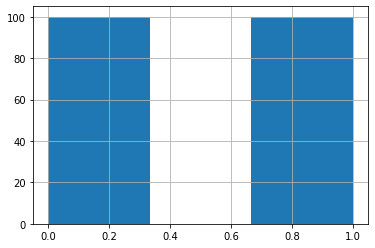

In [6]:
labels_df['hemorrhage'].hist(bins = 3) #2개의 아이템을 그래프로 표현하지만 구분을 위해서 3개로 나눔

뇌출혈인지 여부가 0과 1로 구성되어 있고 각각 100개씩 존재하고 있음을 알 수 있다.

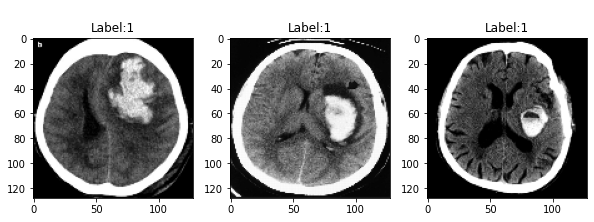

In [7]:
plt.figure(figsize=(10, 10))
for i in range(0, 3):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.title("\nLabel:{}".format(labels[i]))
plt.show()

## 03_data_split

train (80%), validation (10%) and test (10%) 나누기

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=1)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=1)
print(train_images.shape, val_images.shape)
print(train_labels.shape, val_labels.shape)
print((len(train_images), len(val_images), len(test_images)))

(160, 128, 128) (20, 128, 128)
(160,) (20,)
(160, 20, 20)


## 04_image_data_generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
seed(1337)
tf.random.set_seed(1337)


nb_train_samples = len(train_images)
nb_validation_samples = len(val_images)
epochs = 100
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(
    train_images[..., np.newaxis],
    train_labels,
    batch_size=batch_size)

validation_generator = val_datagen.flow(
    val_images[..., np.newaxis],
    val_labels,
    batch_size=batch_size)

## 05_CNN_modeling

1. CNN 모델 만들기

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K

input_shape = (img_width, img_height, 1)

model = None

model = Sequential()

#Below we have the first Convolutional Layer

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

2. 모델 학습시키기

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
16/16 [==============================] - 31s 61ms/step - loss: 0.9898 - accuracy: 0.5187 - val_loss: 0.6995 - val_accuracy: 0.3500
Epoch 2/100
16/16 [==============================] - 0s 27ms/step - loss: 0.6784 - accuracy: 0.5235 - val_loss: 0.7042 - val_accuracy: 0.3500
Epoch 3/100
16/16 [==============================] - 0s 27ms/step - loss: 0.6804 - accuracy: 0.5091 - val_loss: 0.7000 - val_accuracy: 0.3500
Epoch 4/100
16/16 [==============================] - 0s 27ms/step - loss: 0.6320 - accuracy: 0.6638 - val_loss: 0.6902 - val_accuracy: 0.3500
Epoch 5/100
16/16 [==============================] - 0s 27ms/step - loss: 0.5752 - accuracy: 0.7269 - val_loss: 0.6157 - val_accuracy: 0.7000
Epoch 6/100
16/16 [==============================] - 0s 28ms/step - loss: 0.6037 - accuracy: 0.6662 - val_loss: 0.5803 - val_accuracy: 0.7000
Epoch 7/100
16/16 [==============================] - 0s 27ms/step - loss: 0.6215 - accuracy: 0.6607 - val_loss: 0.5009 - val_accuracy: 0.7500
Epoch

## 06_estimation

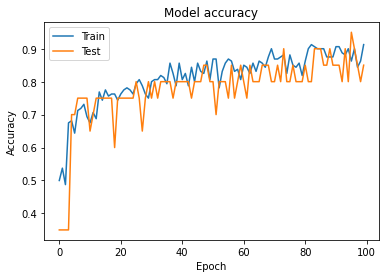

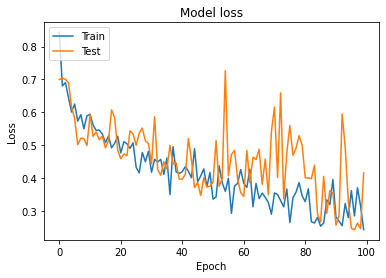

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
model.evaluate(test_images[..., np.newaxis] / 255., test_labels)

1/1 [==============================] - 0s 254ms/step - loss: 0.1806 - accuracy: 0.9000


[0.1806056797504425, 0.8999999761581421]